In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
import numpy as np
import numpy as np

from omegaconf import OmegaConf

from nlp.datasets.datamodule import Datamodule
from nlp.lightning_model.flow_model import FlowModel

/home/konradkaranowski/shape-gan/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/konradkaranowski/nlp-classes/source/nlp/datasets/datamodule.py:218: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path=os.environ["CONFIG_DIR"], config_name="default")
/home/konradkaranowski/nlp-classes/source/nlp/lightning_model/flow_model.py:102: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1


# Load the data

In [2]:
datamodule_config = OmegaConf.load('/home/konradkaranowski/nlp-classes/source/nlp/config/datamodule/herbert.yaml')

In [3]:
datamodule = Datamodule(**datamodule_config)
datamodule.prepare_data()
datamodule.setup('test')
dataset = datamodule.train_dataloader().dataset

2024-01-09 20:10:29 - INFO - Loaded the data from /home/konradkaranowski/storage/nlp/herbet_df.csv


# Load the models

In [4]:
DEVICE = torch.device('cuda')

In [5]:
NICE_PATH = '/home/konradkaranowski/nlp-classes/storage/nlp/outputs/flow_uncertainty/runs/2024-01-09_17-37-39/checkpoints/epoch_007.ckpt'
MAF_PATH = '/home/konradkaranowski/nlp-classes/storage/nlp/outputs/flow_uncertainty/runs/2024-01-09_16-21-00/checkpoints/epoch_016.ckpt'
REAL_NVP_PATH = '/home/konradkaranowski/nlp-classes/storage/nlp/outputs/flow_uncertainty/runs/2024-01-09_19-47-47/checkpoints/epoch_002.ckpt'

In [6]:
nice_flow = FlowModel.load_from_checkpoint(NICE_PATH) 
nice_flow.eval()
nice_flow.to(DEVICE)
pass

2024-01-09 20:10:29 - DEBUG - open file: /home/konradkaranowski/nlp-classes/storage/nlp/outputs/flow_uncertainty/runs/2024-01-09_17-37-39/checkpoints/epoch_007.ckpt
2024-01-09 20:10:31 - INFO - Created a temporary directory at /tmp/tmpkmoxndqu
2024-01-09 20:10:31 - INFO - Writing /tmp/tmpkmoxndqu/_remote_module_non_scriptable.py


In [7]:
maf_flow = FlowModel.load_from_checkpoint(MAF_PATH)
maf_flow.eval()
maf_flow.to(DEVICE)
pass

2024-01-09 20:10:31 - DEBUG - open file: /home/konradkaranowski/nlp-classes/storage/nlp/outputs/flow_uncertainty/runs/2024-01-09_16-21-00/checkpoints/epoch_016.ckpt


In [8]:
real_nvp_flow = FlowModel.load_from_checkpoint(REAL_NVP_PATH)
real_nvp_flow.eval()
real_nvp_flow.to(DEVICE)
pass

2024-01-09 20:10:32 - DEBUG - open file: /home/konradkaranowski/nlp-classes/storage/nlp/outputs/flow_uncertainty/runs/2024-01-09_19-47-47/checkpoints/epoch_002.ckpt


# Helpers

In [9]:
def sample_from_model(model: FlowModel, x: torch.Tensor, context: torch.Tensor, num_samples: int = 100) -> torch.Tensor:
    context = context.to(model.device)
    with torch.no_grad():
        sample, log_prob = model.flow.sample_and_log_prob(num_samples=num_samples, context=context)
    return sample.cpu(), log_prob.cpu()

In [10]:
def get_random_samples(dataset: int, n: int):
    indexes = list(range(len(dataset)))
    choices = np.random.choice(indexes, size=n)
    return [dataset[i] for i in choices], choices

# Sample

In [11]:
NUM_SAMPLES = 5
NUM_SAMPLES_PER_FLOW = 50
GOOD_EXAMPLES = [1999, 45982, 12208, 234, 211]

In [12]:
examples = [dataset[i] for i in GOOD_EXAMPLES]

In [13]:
for sample in examples:
    print(f'Text: {sample["text"]} Decade: {sample["y"]}')

Text: Obecnie proszę o zabranie głosu pana posła Wojciecha Arkuszewskiego z Klubu Parlamentarnego NSZZ ˝Solidarność˝. Następnym mówcą będzie pan poseł Antoni Tokarczuk. Decade: 3
Text: Procedowany projekt ustawy jest kolejnym bardzo ważnym rządowym projektem, który w sposób znaczący przyczyni się do poprawy jakości świadczonych usług medycznych. Decade: 1
Text: Kto się wstrzymał? Decade: 1
Text: Henryk Górski Decade: 2
Text: Tak. Decade: 1


In [14]:
results = []
for sample in examples:
    results_group = []
    for model_name, model in zip(['MAF', 'NICE', 'RealNVP'], [maf_flow, nice_flow, real_nvp_flow]):
        flow_samples, log_prob = sample_from_model(model=model, x=sample['y'], context=sample['x'].unsqueeze(0), num_samples=NUM_SAMPLES_PER_FLOW)
        
        results_group.append({
            'samples': flow_samples,
            'log_prob': log_prob,
            'model': model_name
        })
    results.append(results_group)

2024-01-09 20:10:33 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-01-09 20:10:33 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-01-09 20:10:33 - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2024-01-09 20:10:33 - DEBUG - findfont: score(FontEntry(fname='/home/konradkaranowski/shape-gan/venv/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/cmex10.ttf', name='cmex10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2024-01-09 20:10:33 - DEBUG - findfont: score(FontEntry(fname='/home/konradkaranowski/shape-gan/venv/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralItalic.ttf', name='STIXGeneral', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2024-01-09 20:10:33 - DEBUG - findfont: score(FontEntry(fname='/home/konradkaranowski/shape-g

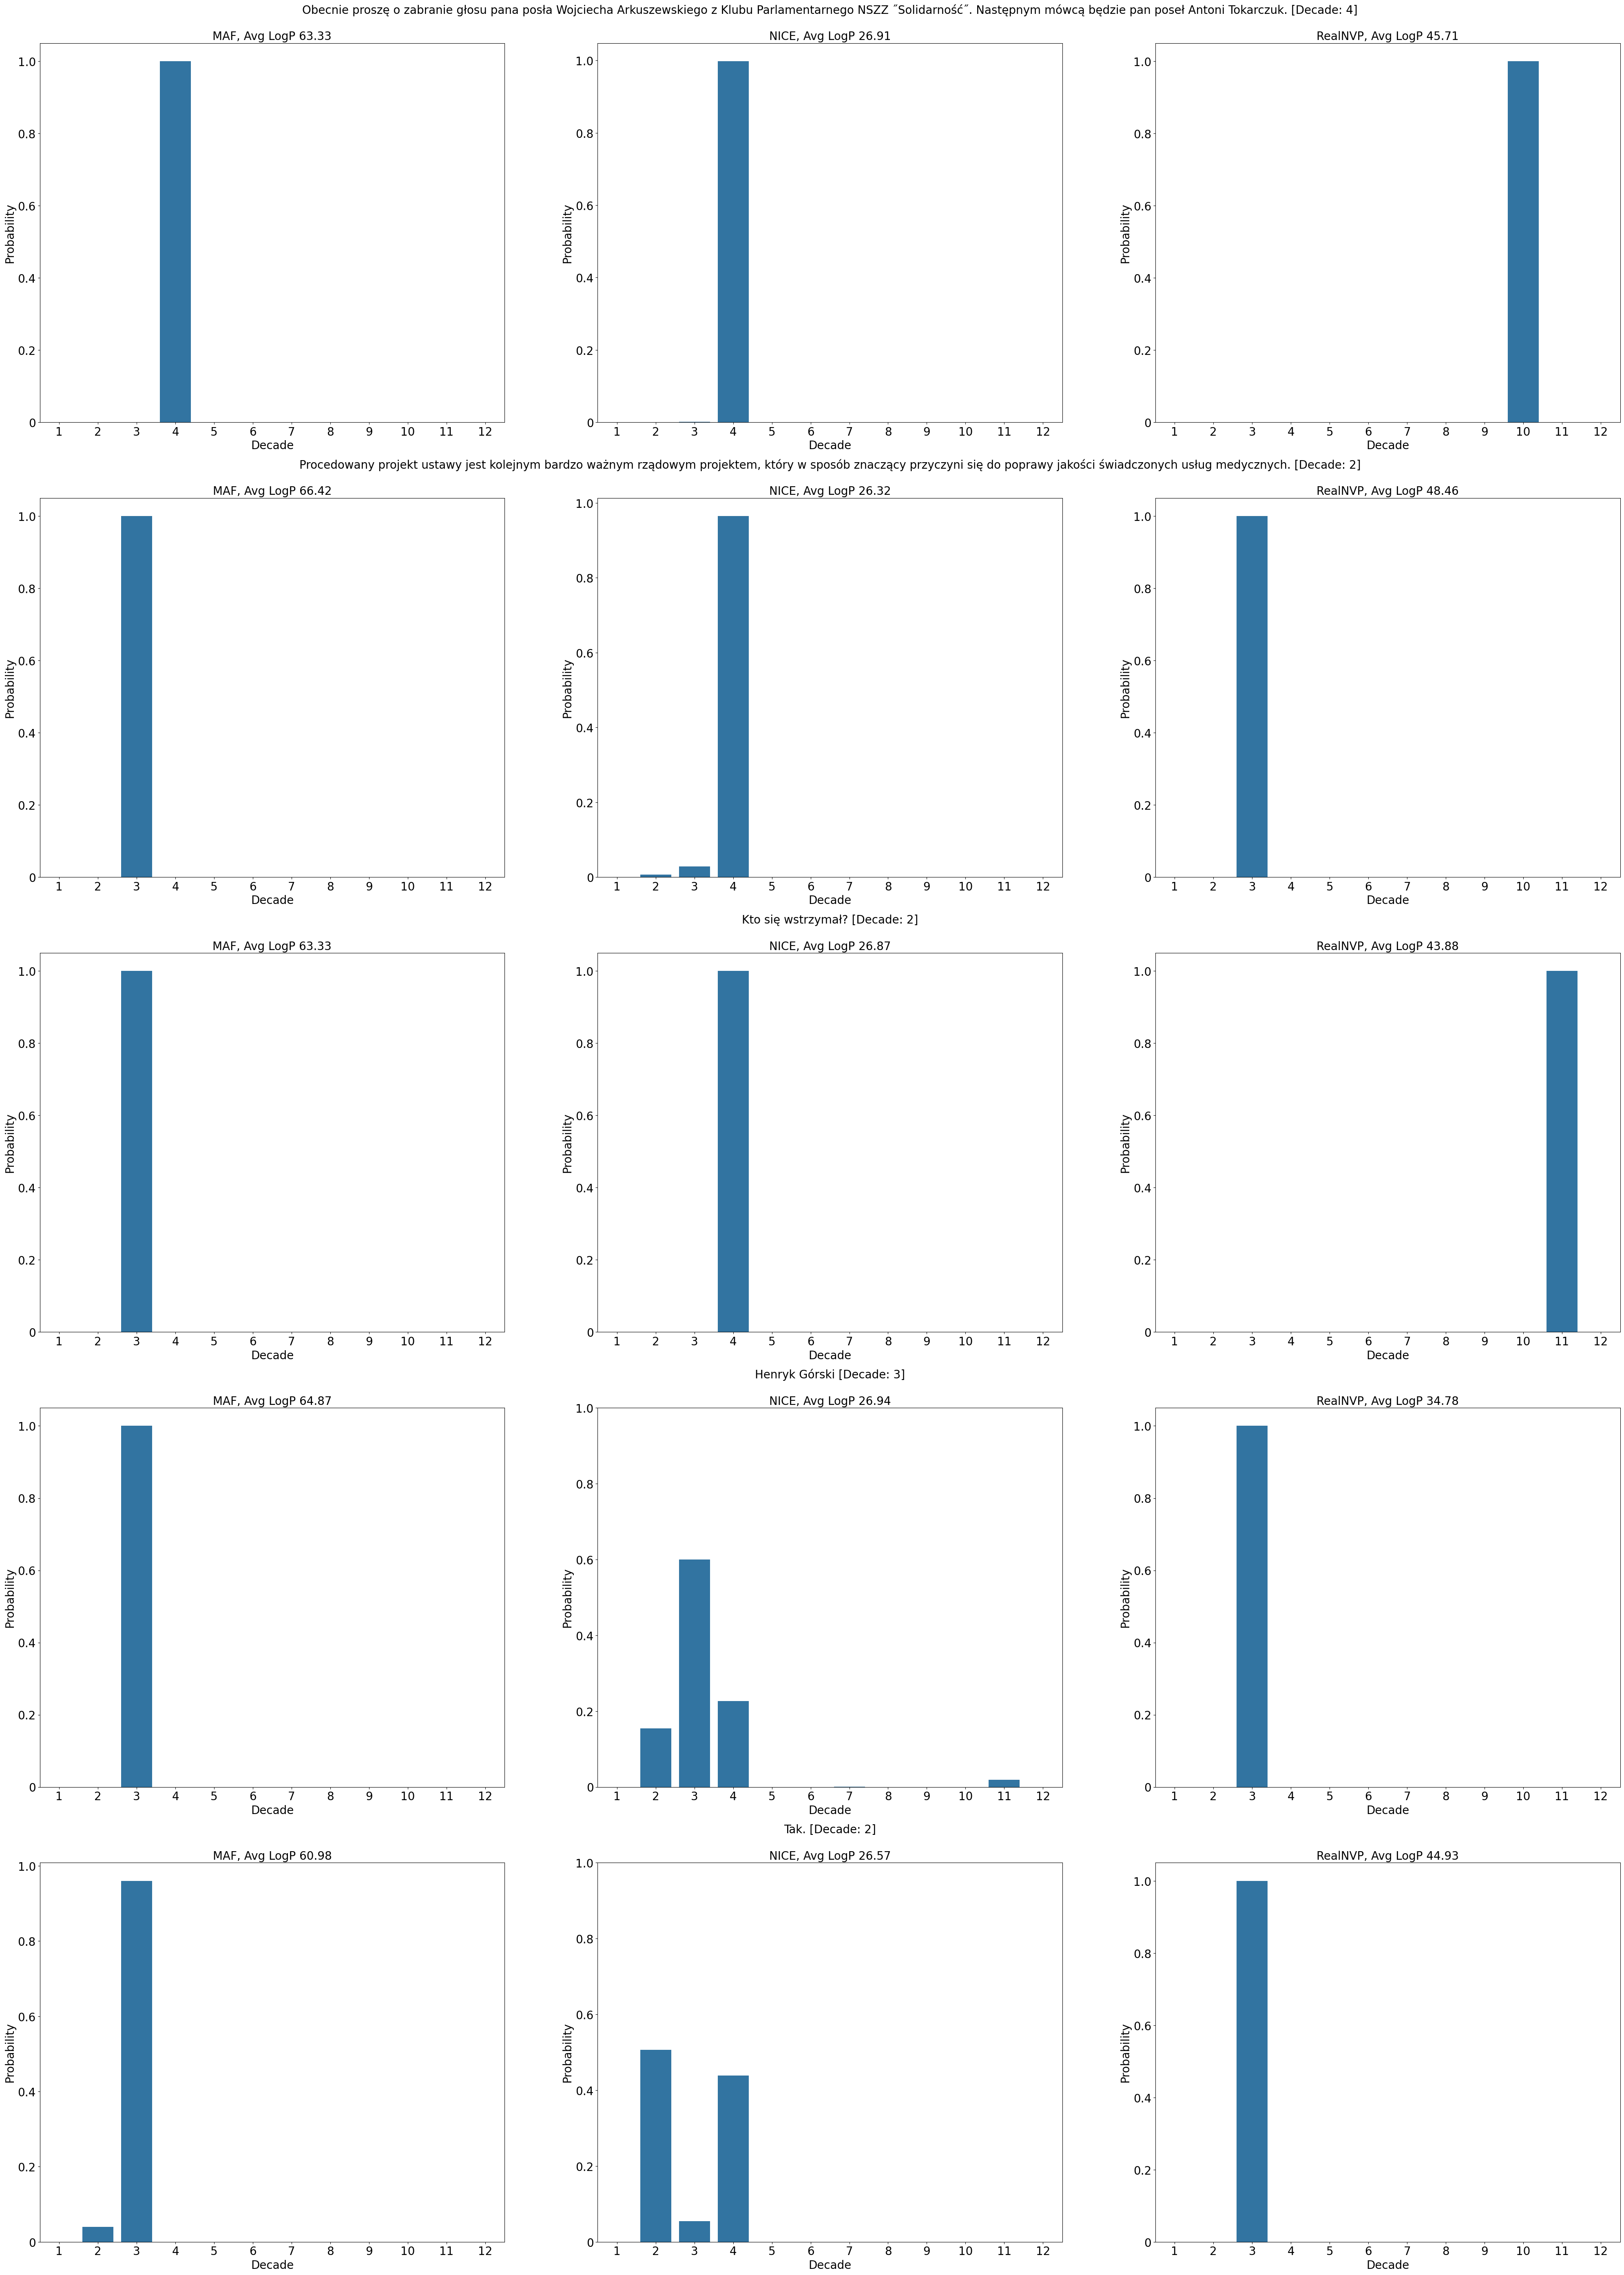

In [15]:
fig, ax = plt.subplots(
    len(results), 
    3, 
    figsize=(50, 70)
)

for i in range(len(results)):
    for j in range(3):
        axij = ax[i, j]
        
        input_ = examples[i]
        text, y = input_['text'], input_['y']
        
        flow_samples = results[i][j]
        samples, log_prob, model = flow_samples['samples'], flow_samples['log_prob'], flow_samples['model']
        
        dist = samples.sum(dim=1)
        
        samples_softmax = torch.nn.functional.softmax(dist, dim=1)[0]
        
        avg_log_prob = log_prob.mean()
        sns.barplot(x=[i for i in range(1, 13)], y=samples_softmax, ax=axij)
        preamb = f'{text} [Decade: {y + 1}]\n\n' if j == 1 else '\n\n'
        axij.set_title(f'{preamb}{model}, Avg LogP {round(avg_log_prob.item(), 2)}', fontdict={'fontsize': 20})
        axij.set_xlabel('Decade', fontdict={'fontsize': 20})
        axij.set_ylabel(f'Probability', fontdict={'fontsize': 20})
        axij.set_xticks([f'{i}' for i in range(1, 13)], labels=[f'{i}' for i in range(1, 13)], fontdict={'fontsize': 20})
        axij.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], labels=[0, 0.2, 0.4, 0.6, 0.8, 1.0], fontdict={'fontsize': 20})

plt.show()